# I. Introduction
Selling your car is never easy, especially when the dealer always want to maximize their profit by cut off as much as 500 dollars for every small ding/dense (maybe not that much, but that probably what everyone feels). We have some helpful site such as KBB, Edmund, etc., to check the potential price for the car, but do you know that they also have a version for car dealer, which basically help the car dealer to cut off the money they need to pay for your car. So, I'm trying to create a model to predict the sale price of a used car, based on a very useful data from Kaggle. This data contains listing data from Craiglist, including all the advertising and private owner listing. I hope I can get more data from other site such as eBay or CarGurus, but unfortunately, they don't share it for free.

The data will be from Kaggle: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

# II. Data Wrangling

### 1. Import

In [1]:
#Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import datetime as dt
import pandas_profiling
from library.sb_utils import save_file

In [2]:
#Import data
vehicle_data = pd.read_csv('../data/vehicles.csv', index_col=0)

### 2. Explore the data

In [3]:
vehicle_data.head()

id                                                url  region  \
0  7240372487  https://auburn.craigslist.org/ctd/d/auburn-uni...  auburn   
1  7240309422  https://auburn.craigslist.org/cto/d/auburn-201...  auburn   
2  7240224296  https://auburn.craigslist.org/cto/d/auburn-200...  auburn   
3  7240103965  https://auburn.craigslist.org/cto/d/lanett-tru...  auburn   
4  7239983776  https://auburn.craigslist.org/cto/d/auburn-200...  auburn   

                      region_url  price    year manufacturer  \
0  https://auburn.craigslist.org  35990  2010.0    chevrolet   
1  https://auburn.craigslist.org   7500  2014.0      hyundai   
2  https://auburn.craigslist.org   4900  2006.0          bmw   
3  https://auburn.craigslist.org   2000  1974.0    chevrolet   
4  https://auburn.craigslist.org  19500  2005.0         ford   

                  model  condition    cylinders  ... drive       size    type  \
0  corvette grand sport       good  8 cylinders  ...   rwd        NaN   other   
1                sonata  excellent  4 cylinders  ...   fwd        NaN   sedan   
2               x3 3.0i       good  6 cylinders  ...   NaN        NaN     SUV   
3                  c-10       good  4 cylinders  ...   rwd  full-size  pickup   
4           f350 lariat  excellent  8 cylinders  ...   4wd  full-size  pickup   

  paint_color                                          image_url  \
0         NaN  https://images.craigslist.org/00N0N_ipkbHVZYf4...   
1         NaN  https://images.craigslist.org/00s0s_gBHYmJ5o7y...   
2        blue  https://images.craigslist.org/00B0B_5zgEGWPOrt...   
3        blue  https://images.craigslist.org/00M0M_6o7KcDpArw...   
4        blue  https://images.craigslist.org/00p0p_b95l1EgUfl...   

                                         description state        lat  \
0  Carvana is the safer way to buy a car During t...    al  32.590000   
1  I'll move to another city and try to sell my c...    al  32.547500   
2  Clean 2006 BMW X3 3.0I.  Beautiful and rare Bl...    al  32.616807   
3  1974 chev. truck (LONG BED) NEW starter front ...    al  32.861600   
4  2005 Ford F350 Lariat (Bullet Proofed). This t...    al  32.547500   

        long              posting_date  
0 -85.480000  2020-12-02T08:11:30-0600  
1 -85.468200  2020-12-02T02:11:50-0600  
2 -85.464149  2020-12-01T19:50:41-0600  
3 -85.216100  2020-12-01T15:54:45-0600  
4 -85.468200  2020-12-01T12:53:56-0600  

[5 rows x 25 columns]

In [4]:
vehicle_data.head(1).T

0
id                                                   7240372487
url           https://auburn.craigslist.org/ctd/d/auburn-uni...
region                                                   auburn
region_url                        https://auburn.craigslist.org
price                                                     35990
year                                                       2010
manufacturer                                          chevrolet
model                                      corvette grand sport
condition                                                  good
cylinders                                           8 cylinders
fuel                                                        gas
odometer                                                  32742
title_status                                              clean
transmission                                              other
VIN                                           1G1YU3DW1A5106980
drive                                                       rwd
size                                                        NaN
type                                                      other
paint_color                                                 NaN
image_url     https://images.craigslist.org/00N0N_ipkbHVZYf4...
description   Carvana is the safer way to buy a car During t...
state                                                        al
lat                                                       32.59
long                                                     -85.48
posting_date                           2020-12-02T08:11:30-0600

There are 25 columns for each data, and most of useful data for our prediction is here. However one of the most important data is listing duration or selling date is missing. Originally I wanted to also predict the listing time, but since we don't have this data, we probably will just stay with predicting the used car sale price.

There are a few columns that are not really useful, such as url, region_url, image_url, VIN. We will drop all these columns to make the data more relevant to what we need

In [5]:
vehicle_data= vehicle_data.drop(axis=1, columns=['url', 'region_url', 'image_url', 'id'])

Now if we notice, we have both state and region in our data, this is due to Craiglist website always have a region to make the searching/listing easier.

In [6]:
vehicle_data[['state', 'region']][vehicle_data.state != vehicle_data.region].count()

state     458213
region    458213
dtype: int64

In [7]:
vehicle_data.shape

(458213, 21)

So basically all the state and region data are different. But do we need both to predict the sale price? I don't think the sale price would be too different from state to state/region to region. Someone might argue that cars, especially used one, might be cheaper in rural area since supply > demand, or dealers over there don't have high cost compare to those in the cities. So I will leave both state and region here for now.

In [8]:
vehicle_data.dtypes

region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

So, look at the types, we have mostly object type, which is category type. The year somehow is float and the posting_date is object, while they suppose to be datetime. We will need to change those to the correct type. But one thing I notice is that instead of using year, which potentially be a big category variable, let calculate the age of the car instead and drop the year column, so that we have more insightful data. We probably should do the same for posting_data.

In [9]:
vehicle_data.year[~vehicle_data.year.isnull()].sort_values()

424893    1900.0
426202    1900.0
425955    1900.0
453746    1900.0
427453    1900.0
           ...  
384146    2021.0
222587    2021.0
351168    2021.0
344905    2021.0
202262    2021.0
Name: year, Length: 457163, dtype: float64

In [10]:
#Calculate age of car
vehicle_data['age'] = 2021 - vehicle_data.year
vehicle_data.age

0         11.0
1          7.0
2         15.0
3         47.0
4         16.0
          ... 
458208     7.0
458209     3.0
458210     7.0
458211    13.0
458212    13.0
Name: age, Length: 458213, dtype: float64

In [11]:
vehicle_data.posting_date[~vehicle_data.posting_date.isnull()].sort_values()

394046    2020-10-22T22:58:26-0600
362443    2020-10-28T18:32:34-0400
59447     2020-11-03T00:11:29-0800
24782     2020-11-03T00:26:37-0800
57633     2020-11-03T01:37:01-0800
                    ...           
455985    2020-12-03T11:26:27-0500
456417    2020-12-03T11:27:37-0500
457554    2020-12-03T11:28:33-0500
457541    2020-12-03T11:29:57-0500
457550    2020-12-03T11:31:31-0500
Name: posting_date, Length: 458185, dtype: object

This is not good. Now we see that posting_date range only from October - December 2020. We can try to get something out of it but this is too small range to have any affect on the sale price, probably affect the listing number since dealers always have promotion when Christmas come. We probably will remove this column.

Now, let's check our data using panda profiling.

In [12]:
report = vehicle_data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

So looking at the profiling, I notice a few things:
- Price: Max is 3615215112, min is 0, mean is 40420.9 and missing 7.4%. This means many of these data are either typos or advertising, which does not give us the real price for the vehicle. Those will need to be cleaned up.
- Year: ranging from 1900 to 2021, while the latest posting date was 12/2020. This means some of the data is for new car. Will also clean this up.
- Odometer: 0 to 2043755555 miles. In general, a used car should be about 500 miles (some dealers also sell new car with a couple of hundreds miles, this is model car but still being considered "new" because it did not have owner yet) and up to about 500,000 mileage, maybe more but seriously who would buy a car that has run more than 500,000 miles. We will need to clean this up also.
- Condition missing 42.1%, size missing 70.1%. We probably going to drop these columns due to high null data. Such a waste because I believe the condition is one of the most important info of used car, which could drive the price up or down drastically. Hopefully other features can make up for this.
- Description: we have total of 457163 row in our data but only 384347 distinct description. What does this mean? There are a lot of duplication. You can have the same car, model, color, etc. but the same description in a free text box only indicate that people are spamming, and the one who is spamming the most probably the car dealers. And that's true when looking at the most frequent duplicate rows. But not all are fake/unuseful data. We still can use many of them, just need to remove the duplicate versions. One thing to notice that there are only 26 duplicate rows (whole row, not description only), which makes this clean up job a lot more difficult.

Ok, so now let's clean up the dataset by first remove all the duplicate. This would save us some headaches.

In [13]:
vehicle_data = pd.DataFrame.drop_duplicates(vehicle_data)

Next, let's clean up the most important column: price. 
I will use 4 important pieces of info to determine if the price is plausible or not: price (of course), year, manufacturer and description (to investigate the listing)

In [14]:
pd.set_option('display.max_colwidth', None)
vehicle_data[['price', 'year', 'manufacturer', 'description']].sort_values('price', ascending = False).head(20)

price    year manufacturer  \
385434  3615215112  2006.0    chevrolet   
425188  2857993261  2003.0         jeep   
38375   2808348671  2020.0          gmc   
1622    1234567890  1955.0    chevrolet   
414603   123456789  2002.0         ford   
414605   123456789  2006.0          NaN   
326182   123456789  1939.0     chrysler   
306217   123456789  2018.0          ram   
339197   123456789  1969.0    chevrolet   
339213   123456789  2009.0         jeep   
393667   100000000  1961.0          NaN   
238861    98504250  2008.0         ford   
191736    79000000  1955.0     cadillac   
362163    50000000  1955.0     cadillac   
174403    22000000  2015.0       toyota   
145053    12345679  2006.0         jeep   
256573    12345678  2004.0       toyota   
25413     11111111  2007.0       nissan   
109654    11111111  1970.0          NaN   
360640    11111111  1966.0    chevrolet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  description  
385434                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               2006 Chevrolet Silverado 2500 HD 4x4 LBZ low miles  Truck has 117,500 miles.  Clean cloth interior.  It does have an EGR delete.  Truck has some surface rust on the frame and the rear passenger window track and motor are broken.  Asking $16,500  Call or text 80six-4four1-98three3  
425188                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Looking at our top 20 highest price. None of them is actual price. The description of the first listing says they asking for 16,500, but the price is like random number that was put in. We can change this to 16,500, and remove the rest of the top 20 since they are not real data.

In [15]:
vehicle_data.price.iloc[385434] = 16500

C:\Users\hyuwo\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-15-eeb2f951b7c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data.price.iloc[385434] = 16500


In [16]:
clean_data = vehicle_data.drop(vehicle_data[vehicle_data.price >= 11111111].index)
clean_data.price.sort_values(ascending=False)

107009    9999999
191738    7900000
109428    3429900
370801    2015200
167398    1234567
           ...   
221165          0
121208          0
30425           0
30424           0
115817          0
Name: price, Length: 458167, dtype: int64

Investigate the next 150 rows, I found some infomation:
- Many of them are just random number for advertising purpose, like 9999999 or 7900000, which we probably will drop it.
- Many of them are super cars that are very expensive: Ferrari, Lamborghini, Jeep Grand Cherokee Trackhawk, Porsche, etc.
- Some of them are typos, for example they type 219995 instead of 21995 like in the description.

Since our used car most likely will be a regular car (who sell their Ferrari on Craiglist anyway?), we will remove all the outliners by formula: mean + 2*std. But before that, let's explore our cheapest car.

In [17]:
clean_data[['price', 'year', 'manufacturer', 'description']].sort_values('price').head(10)

price    year manufacturer  \
115817      0  2012.0        honda   
30424       0  2012.0        acura   
30425       0  2016.0         ford   
121208      0  2016.0        honda   
221165      0  2011.0    chevrolet   
30429       0  2017.0         ford   
30430       0  2018.0       toyota   
30431       0  2019.0         ford   
325140      0  2017.0    chevrolet   
221163      0  2019.0        mazda   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

As we can see, all of these are just advertising. In my opinion, any used car that we put on Craiglist will be at least \\$1000, otherwise we just sell it for the state (California has the program buying old vehicle back for \\$1000), or just donate it. Therefore I will just remove any car that is priced under \\$1000.

In [18]:
clean_data[['price', 'year', 'description']][clean_data.price < 1000].sort_values('price', ascending=False).head(10)

price    year  \
67708     999  2011.0   
168988    999  2014.0   
170574    999  2013.0   
170571    999  2013.0   
170516    999  2013.0   
170498    999  2009.0   
427997    999  2019.0   
321008    999  2000.0   
170467    999  2013.0   
108639    999  2010.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [19]:
clean_data = clean_data.drop(clean_data[clean_data.price < 1000].index)

Now let's remove the outliners

In [20]:
thres = np.mean(clean_data.price) + 2 * np.std(clean_data.price)
clean_data = clean_data.drop(clean_data[clean_data.price > thres].index)

<AxesSubplot:>

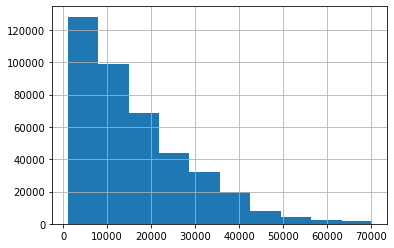

In [21]:
clean_data.price.hist()

Ok so our data now will be from \\$1000 to about \\$70000, which is a good range for a used car.

Next let's take a look at the odometer. As we discussed, a used car should have odometer > 500, and should not be over 500,000. Anything out of that range should be removed.

In [22]:
clean_data = clean_data.drop(clean_data[(clean_data.odometer > 500000)].index)
clean_data = clean_data.drop(clean_data[(clean_data.odometer < 500)].index)

<AxesSubplot:>

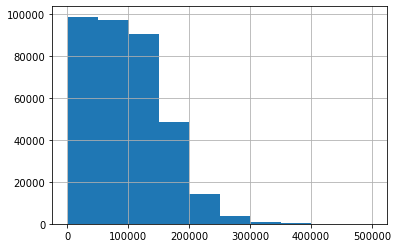

In [23]:
clean_data.odometer.hist()

Now let's drop the high missing % columns and unuse columns

In [24]:
missing = pd.concat([clean_data.isnull().sum(), 100 * clean_data.isnull().mean()], axis=1)
missing.columns = (['count', '%'])
missing.sort_values('%')

count          %
region             0   0.000000
price              0   0.000000
state              0   0.000000
posting_date      18   0.004503
description       60   0.015010
age              865   0.216400
year             865   0.216400
transmission    1713   0.428547
title_status    1780   0.445308
fuel            2388   0.597414
lat             2719   0.680221
long            2719   0.680221
model           3831   0.958414
manufacturer   13762   3.442884
odometer       45049  11.270055
type           96251  24.079425
drive         113363  28.360390
paint_color   114498  28.644336
cylinders     144128  36.056969
condition     158165  39.568651
VIN           164426  41.134986
size          279652  69.961448

In [25]:
clean_data = clean_data.drop(columns=['year', 'size', 'VIN', 'posting_date'], axis=1)

In [26]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399723 entries, 0 to 458212
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        399723 non-null  object 
 1   price         399723 non-null  int64  
 2   manufacturer  385961 non-null  object 
 3   model         395892 non-null  object 
 4   condition     241558 non-null  object 
 5   cylinders     255595 non-null  object 
 6   fuel          397335 non-null  object 
 7   odometer      354674 non-null  float64
 8   title_status  397943 non-null  object 
 9   transmission  398010 non-null  object 
 10  drive         286360 non-null  object 
 11  type          303472 non-null  object 
 12  paint_color   285225 non-null  object 
 13  description   399663 non-null  object 
 14  state         399723 non-null  object 
 15  lat           397004 non-null  float64
 16  long          397004 non-null  float64
 17  age           398858 non-null  float64
dtypes: f

Eventhough we are not going to use some columns such as region, state, lat, long. It would be nice to just keep them for future use in data visualization.

Now we are done. Export the file and go to the next steps.

In [28]:
datapath = '../data'
save_file(clean_data, 'vehicle_data_cleaned.csv', datapath)

Writing file.  "../data\vehicle_data_cleaned.csv"
